In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,ElasticNetCV,ElasticNet
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score


df=pd.read_csv(r"C:\Users\Administrator\Desktop\nairobi\nairobi_housing_dataset.csv")
df.head()

,price,sqft,bedrooms,bathrooms,house_age,distance_to_city_center_km,crime_rate_index
0,13264671,2559,3,1,22,7.3,68.94
1,12248803,2369,3,3,32,3.6,28.38
2,12555632,2023,3,1,16,6.6,69.39
3,13356744,1741,4,3,18,24.8,30.58
4,11979569,2279,5,1,5,20.6,75.92


In [2]:
df.duplicated().sum()

0

In [3]:
df.isnull().sum()

price                         0
sqft                          0
bedrooms                      0
bathrooms                     0
house_age                     0
distance_to_city_center_km    0
crime_rate_index              0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   price                       1000 non-null   int64  
 1   sqft                        1000 non-null   int64  
 2   bedrooms                    1000 non-null   int64  
 3   bathrooms                   1000 non-null   int64  
 4   house_age                   1000 non-null   int64  
 5   distance_to_city_center_km  1000 non-null   float64
 6   crime_rate_index            1000 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 54.8 KB


EDA


In [5]:
df.describe()

,price,sqft,bedrooms,bathrooms,house_age,distance_to_city_center_km,crime_rate_index
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,1.135957e+07,2027.836000,2.955000,2.039000,25.293000,15.450700,49.44732
std,1.762285e+06,398.986698,1.431441,0.817403,13.986521,8.278486,29.09617
min,6.529933e+06,823.000000,1.000000,1.000000,1.000000,1.000000,0.06000
25%,1.025328e+07,1756.750000,2.000000,1.000000,14.000000,8.400000,23.75750
50%,1.134807e+07,2024.500000,3.000000,2.000000,25.000000,15.500000,49.91500
75%,1.251101e+07,2291.500000,4.000000,3.000000,38.000000,22.600000,73.14750
max,1.827350e+07,3277.000000,5.000000,3.000000,49.000000,30.000000,99.98000


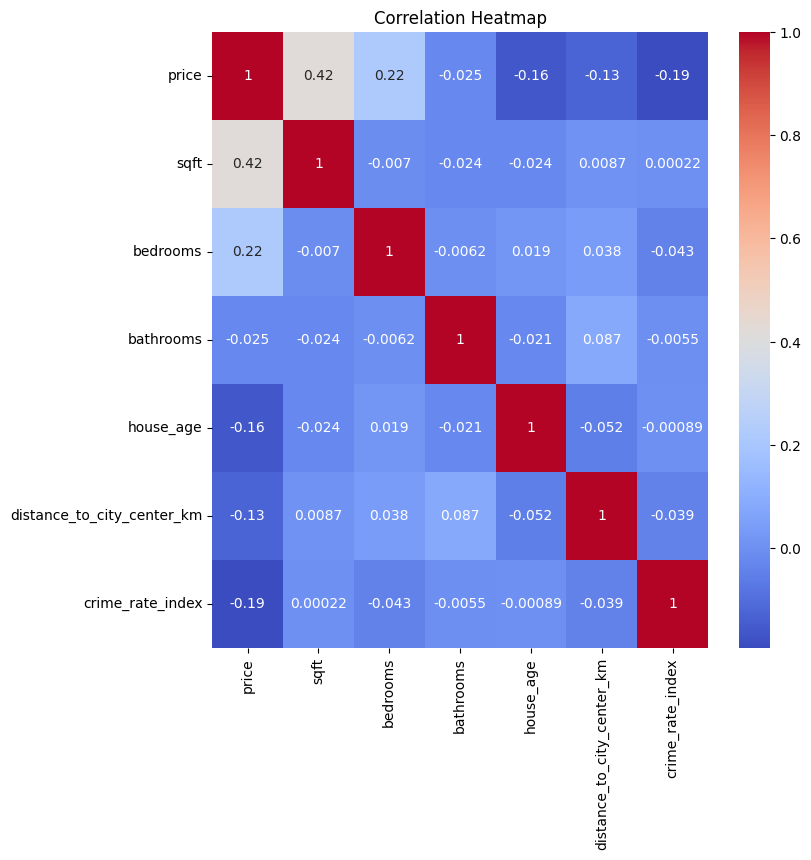

In [7]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Crime rate and house age negatively correlate with the house price whereas sqrft correlate positively with the price of the house


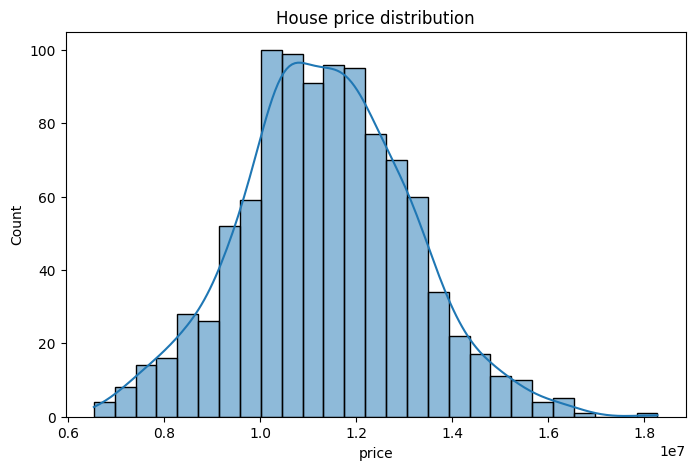

In [8]:
# price distribution

plt.figure(figsize=(8,5))
sns.histplot(df['price'],kde=True)
plt.title("House price distribution")
plt.xlabel('price')
plt.show()

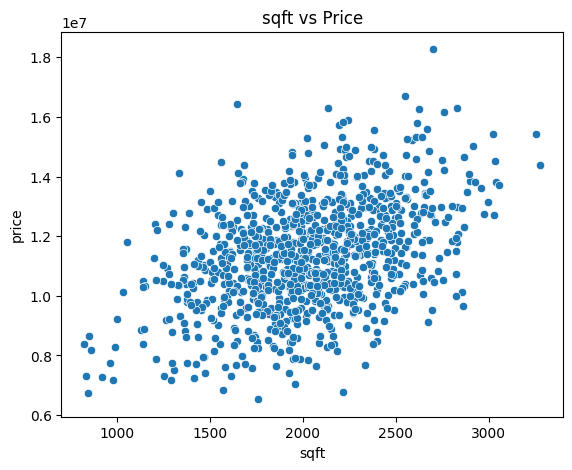

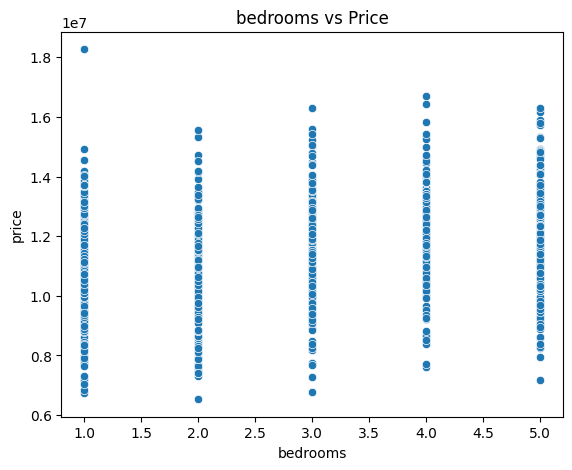

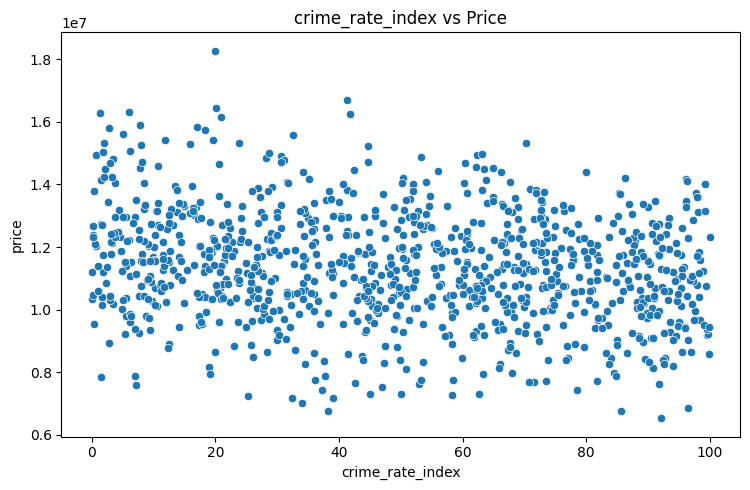

In [15]:
features=['sqft','bedrooms','crime_rate_index']

for i,col in enumerate(features):
    plt.figure(figsize=(22,5))
    plt.subplot(1,3,i+1)
    sns.scatterplot(data=df,x=col,y='price')
    plt.title(f"{col} vs Price")

plt.tight_layout()
plt.show()

## Machine learning

In [5]:
# multilinear regression

X=df.drop('price',axis=1)
y=df['price']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=43)

model=LinearRegression()

model.fit(X_train,y_train)

y_pred=model.predict(X_test)



### evaluating the model

In [5]:
mse=mean_squared_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)

print(f"mse {mse}")
print(f"r2_score {r2}")

mse 2180771074235.7944
r2_score 0.2966033024772111


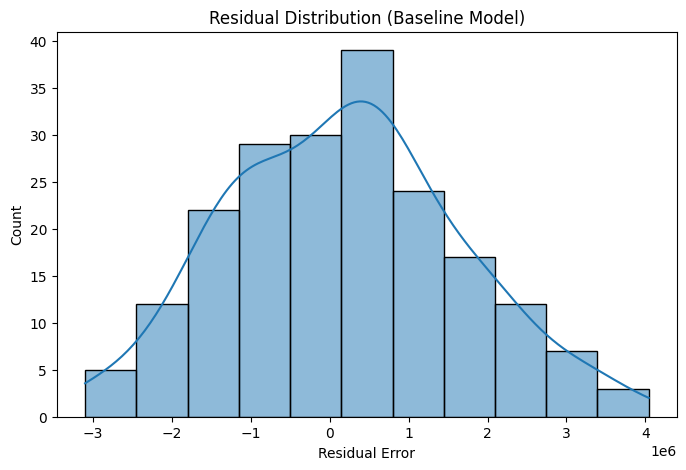

In [20]:
#plot for the residuals 

residual=y_test-y_pred

plt.figure(figsize=(8,5))
sns.histplot(residual,kde=True)
plt.title("Residual Distribution (Baseline Model)")
plt.xlabel("Residual Error")
plt.show()

The model is underfitting


## KFold and cross validation

In [6]:
#kfold is usually good for smaller datasets

kfold=KFold(n_splits=5,shuffle=True,random_state=43)

cv_scores=cross_val_score(model,X,y,cv=kfold,scoring='r2')

cv_scores

array([0.2966033 , 0.32989367, 0.28769797, 0.26272809, 0.3125134 ])

## ridgecv


In [12]:
ridge_cv=RidgeCV(alphas=np.logspace(-3,3,1000),cv=5,scoring='r2')
ridge_cv.fit(X,y)
print(ridge_cv.best_score_)

0.2983830353840035


## lassocv

In [14]:
lassocv=LassoCV(alphas=np.logspace(-4,1,1000),cv=5,max_iter=2000)
lassocv.fit(X,y)
print(lassocv.score(X,y))

0.30763728073731234


In [17]:
elastic_net=ElasticNetCV(alphas=np.logspace(-3,-3,1000),l1_ratio=[0.2,0.5,0.8],max_iter=2000)
elastic_net.fit(X,y)
print(elastic_net.score(X,y))
print(elastic_net.l1_ratio_)

0.30763727321338763
0.2


#### using gridsearchcv and randomizedsearchcv for automation


#### gridsearchcv

In [8]:
# elastic net with gridsearchcv

param_grid={
    'alpha':np.logspace(-3,-3,1000),
    'l1_ratio':[0.2,0.5,0.8],
    'max_iter':[2000]
}

elastic=ElasticNet()

grid_search=GridSearchCV(
    estimator=elastic,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(X,y)
print(grid_search.best_params_)

{'alpha': 0.001, 'l1_ratio': 0.2, 'max_iter': 2000}
